## Import

In [1]:
import pandas as pd
import xlrd
import numpy as np
import matplotlib.pyplot as plt
import csv
import scipy.optimize as opt

## File name and experiment set-up

In [98]:
inhib_file = r'data\MOI 0.01 drug screen 2.xlsx'
tox_file = r'data\Uninfected nCoV drug screen 2.xlsx'
n_plates = 7
n_columns = 12
n_repeats = 3
n_concentrations = 8
start_concentration = 50

## Names of compounds

In [99]:
plate = {} # <--- don't change this line!
# format is plate[number]= ['Compound1', 'Compound2', 'Compound 3']
# e.g. plate[1] = ['FD', 'BM', 'AH']
# don't worry about dmso, that's already taken care of :)
plate[1] = ['FD', 'BM', 'AH']
plate[2] = ['CH', 'TC', 'AD']
plate[3] = ['TM', 'MH', 'T']
plate[4] = ['TV', 'A', 'GH']
plate[5] = ['IM', 'F', 'CH']
plate[6] = ['HS', 'PH', 'ED']
plate[7] = ['CP', 'TaC', 'H2O']
#
plate_names = plate

## Prepare array of concentrations

In [100]:
concentrations = []
concentrations.append(start_concentration)
for i in range(1, n_concentrations):
    concentrations.append(concentrations[i-1]/2)

## Function to read data from excel file into nice dictionary of dataframes

In [101]:
def get_dict_from_excel(filename, n_plates, n_columns, infected=True):
    
    if not infected:
        _n_plates = n_plates+1
    else:
        _n_plates = n_plates
    
    start_identifier = 'Plate:'
    end_identifier = '~End'
    
    book = xlrd.open_workbook(filename=filename)
    sheet = book.sheet_by_index(0)
    row_titles = sheet.col_values(0)
    
    start_indices = []
    end_indices = []
    
    for i in range(len(row_titles)):
        row_title = row_titles[i]
        if row_title==start_identifier:
            start_indices.append(i)
        elif row_title==end_identifier:
            end_indices.append(i)
    
    data = {}
    
    for plate in range(_n_plates):
        
        vals = []
        start = start_indices[plate]+2
        end = end_indices[plate]-1
        
        for col in range(2, 2+n_columns):
            cells = sheet.col_slice(col, start, end)
            for cell in cells:
                vals.append(cell.value)
        
        vals = np.reshape(vals, (n_columns, end-start)).T
        df = pd.DataFrame(data=vals)
        
        for i in range(n_concentrations):
            df.rename(index={i:concentrations[i]}, inplace=True)
           
        if not infected:
            _plate = plate
        else:
            _plate = plate+1
        
        data[f'Plate {_plate}'] = df
        
    return data

## Function to do averaging of repeats

In [102]:
def do_repeat_averaging(df, n_repeats):
    
    n_columns = len(df.columns)
    col_names = df.columns
    
    n_samples = int(n_columns/n_repeats)
    
    df_averaged = pd.DataFrame()
       
    for n in range(n_samples):
        i = n*n_repeats
        j = (n+1)*n_repeats-1
        
        drug = col_names[i][:-2]

        _i = col_names[i]
        _j = col_names[j]
        av_col = df.loc[:,_i:_j].T.mean()
        std_col = df.loc[:,_i:_j].T.std()
        df_averaged[f'Mean {drug}'] = av_col
        df_averaged[f'Std {drug}'] = std_col

    return df_averaged

## Functions for toxicity and inhibition calculation

In [103]:
def get_toxicity(drug, cell, blank=0):
    
    _drug = np.subtract(drug, blank)
    _cell = np.subtract(cell, blank)

    tox = 1 - np.divide(_drug, _cell)
    
    return tox*100

In [104]:
def get_inhibition(drug, cell, vehicle):
    
    _drug = np.subtract(drug, vehicle)
    _cell = np.subtract(cell, vehicle)

    inhib = np.divide(_drug, _cell)
    
    return inhib*100

In [105]:
def get_tox_and_inhib_for_plate(inhib_data, tox_data, plate_number, plate_names, n_repeats, concentrations):
    plate_key = f'Plate {plate_number}'
    drug_names = plate_names[plate_number]
    n_drugs = len(drug_names)
    n_concentrations = len(concentrations)
    
    plate_0 = np.asarray(tox_data['Plate 0']).T
    inhib_array = np.asarray(inhib_data[plate_key]).T
    tox_array = np.asarray(tox_data[plate_key]).T
    
    cell = np.mean(plate_0)
    vehicle = np.mean(inhib_array[9:12], axis=0)
    
    df_inhib = pd.DataFrame()
    df_tox = pd.DataFrame()

    
    for d in range(n_drugs):
        drug = drug_names[d]
        
        for r in range(n_repeats):
            i = d*n_repeats + r

            tox = get_toxicity(tox_array[i], cell)
            inhib = get_inhibition(inhib_array[i], cell, vehicle)
            
            df_inhib[f'{drug}-{r+1}'] = inhib
            df_tox[f'{drug}-{r+1}'] = tox
           
    return df_tox, df_inhib        

## Logistic fitting

In [106]:
def logistic_function(x_vals, top, logEC50, hill_slope):
    x_vals = np.array(x_vals)
    x_vals = np.log10(x_vals)
    bottom = 0
    
    return bottom + (top-bottom)/(1+np.power(10, (logEC50-x_vals)*hill_slope))


def fit_logistic_function(concentrations, responses, verbose=True):
    
    #x_vals = np.log10(concentrations)
    
    params = [100, 0.5, 2]
    
    try:
        popt, pcov = opt.curve_fit(logistic_function, concentrations, responses, p0=params)
    except:
        if verbose:
            print('fitting not possible, sorry!')
        return 0, 0, 0
    
    _top = popt[0]
    _logEC50 = popt[1]
    _hill_slope = popt[2]
    
    _x_vals = np.linspace(concentrations[0], concentrations[-1], 500)
    
    fit = logistic_function(_x_vals, _top, _logEC50, _hill_slope)

    if verbose:
        print(f'Initialised params at: {params}')
        print(f'Optimised params at: {popt}')
        plt.figure()
        plt.plot(concentrations, responses, 'bo', label='raw data')
        plt.plot(_x_vals, fit, 'b', label='fit')
        plt.xscale('log')
    
    return _top, _logEC50, _hill_slope

In [107]:
inhib_data = get_dict_from_excel(inhib_file, n_plates, n_columns)
tox_data = get_dict_from_excel(tox_file, n_plates, n_columns, infected=False)

df_tox, df_inhib = get_tox_and_inhib_for_plate(inhib_data, tox_data, 2, plate_names, n_repeats, concentrations)
df_tox_av = do_repeat_averaging(df_tox, n_repeats)
df_inhib_av = do_repeat_averaging(df_inhib, n_repeats)

In [108]:
inhib_data

{'Plate 1':                       0             1             2             3  \
 50.000000  2.135945e+05  2.065527e+05  1.812108e+05  3.946231e+07   
 25.000000  3.786667e+07  4.115500e+07  3.556772e+07  3.950239e+07   
 12.500000  4.099591e+07  4.134978e+07  4.849828e+07  3.299430e+07   
 6.250000   2.236569e+07  2.419204e+07  2.750285e+07  2.069815e+07   
 3.125000   1.828094e+07  1.927371e+07  2.214138e+07  1.861973e+07   
 1.562500   2.072346e+07  1.786445e+07  1.745889e+07  1.921477e+07   
 0.781250   1.608579e+07  1.609272e+07  2.062930e+07  1.752394e+07   
 0.390625   1.274118e+07  1.608798e+07  1.813143e+07  1.750847e+07   
 
                       4             5             6             7  \
 50.000000  3.869500e+07  4.182256e+07  2.563649e+07  2.277844e+07   
 25.000000  3.450304e+07  3.276255e+07  4.547439e+07  4.488214e+07   
 12.500000  3.220536e+07  2.826660e+07  3.746217e+07  3.241640e+07   
 6.250000   2.170182e+07  2.374487e+07  3.441049e+07  3.748979e+07   
 3.1250

In [109]:
df_inhib

,CH-1,CH-2,CH-3,TC-1,TC-2,TC-3,AD-1,AD-2,AD-3
0,-130.122932,-130.311252,-130.277348,-130.126703,-130.237799,-130.196438,19.178801,13.531969,12.859484
1,-55.553084,-87.621675,-98.982001,115.299012,62.898826,52.014955,180.772658,118.811990,168.647202
2,50.044244,77.551421,81.503357,187.260772,165.037010,163.172445,99.657591,129.826486,148.426334
3,88.552223,144.298989,122.146865,35.893071,105.520807,77.084448,35.157503,69.685784,152.787712
4,6.907422,67.038738,47.598755,14.931256,45.114541,48.261921,69.225252,81.672941,80.481661
5,-26.875538,24.052922,6.556626,6.540068,27.125406,9.270051,25.538835,26.734101,72.889775
6,-14.141606,-9.053315,-3.863882,2.096312,-1.122770,-12.458112,9.277451,11.572100,12.135404
7,-13.921437,-1.515394,-0.184035,14.181316,1.298072,4.614244,18.498203,19.716527,27.956557


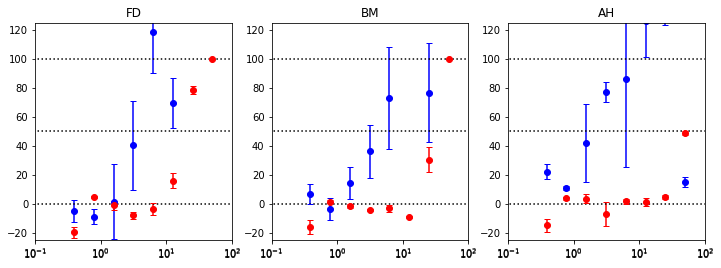

In [110]:
inhib_array = np.asarray(df_inhib_av).T
tox_array = np.asarray(df_tox_av).T

fig, ax = plt.subplots(1,3, figsize=(12,4))

ax[0].errorbar(concentrations, inhib_array[0], inhib_array[1], color='b', marker='o', capsize=3, label='inhibition', linestyle='')
ax[0].errorbar(concentrations, tox_array[0], tox_array[1], color='r', marker='o', capsize=3, label='toxicity', linestyle='')
ax[0].set_title('FD')

ax[1].errorbar(concentrations, inhib_array[2], inhib_array[3], color='b', marker='o', capsize=3, label='inhibition', linestyle='')
ax[1].errorbar(concentrations, tox_array[2], tox_array[3], color='r', marker='o', capsize=3, label='toxicity', linestyle='')
ax[1].set_title('BM')

ax[2].errorbar(concentrations, inhib_array[4], inhib_array[5], color='b', marker='o', capsize=3, label='inhibition', linestyle='')
ax[2].errorbar(concentrations, tox_array[4], tox_array[5], color='r', marker='o', capsize=3, label='toxicity', linestyle='')
ax[2].set_title('AH')


for i in range(3):
    ax[i].set_xscale('log')
    ax[i].set_xticks([0.1, 1, 10, 100], [0.1, 1, 10, 100])
    ax[i].set_ylim([-25, 125])
    ax[i].set_xlim([0.1, 100])
    ax[i].hlines([0, 50, 100], -25, 125, linestyle=':')

In [111]:
def format_plot(xdata, ydata, xlabel=None, ylabel=None, title=None, ylim=None, xticks=None, hlines=None, logx=True):
    
    label_style = ['large', 'semibold']
    marker_style = 'o'
    color_order = ['b','r','g']
    
    plt.figure(figsize=[4.8, 4.8])
    plt.hlines(hlines, xticks[0], xticks[-1], linestyle=':')    
    
    if ydata.ndim==2:       
        for y in ydata:
            plt.plot(xdata, y, marker=marker_style)
    else:
        plt.plot(xdata, ydata, marker=marker_style, color='b')
    
    if logx:
        plt.xscale('log')
        
        
    plt.xlabel(xlabel, fontsize=label_style[0], fontweight=label_style[1])
    plt.ylabel(ylabel, fontsize=label_style[0], fontweight=label_style[1])
            
    plt.tick_params(direction='in')
    plt.xticks(xticks, xticks)


In [112]:
df_inhib

,CH-1,CH-2,CH-3,TC-1,TC-2,TC-3,AD-1,AD-2,AD-3
0,-130.122932,-130.311252,-130.277348,-130.126703,-130.237799,-130.196438,19.178801,13.531969,12.859484
1,-55.553084,-87.621675,-98.982001,115.299012,62.898826,52.014955,180.772658,118.811990,168.647202
2,50.044244,77.551421,81.503357,187.260772,165.037010,163.172445,99.657591,129.826486,148.426334
3,88.552223,144.298989,122.146865,35.893071,105.520807,77.084448,35.157503,69.685784,152.787712
4,6.907422,67.038738,47.598755,14.931256,45.114541,48.261921,69.225252,81.672941,80.481661
5,-26.875538,24.052922,6.556626,6.540068,27.125406,9.270051,25.538835,26.734101,72.889775
6,-14.141606,-9.053315,-3.863882,2.096312,-1.122770,-12.458112,9.277451,11.572100,12.135404
7,-13.921437,-1.515394,-0.184035,14.181316,1.298072,4.614244,18.498203,19.716527,27.956557


In [113]:
def get_arrays(df, _i, _j):
    array = np.asarray(df.loc[:,_i:_j].T)
    mean_array = np.mean(array, axis=0)
    std_array = np.std(array, axis=0)
    array = array.flatten()
    
    return array, mean_array, std_array
        
    
    
def plots_and_fits(df_tox, df_inhib, concentrations, n_repeats):
    n_columns = len(df_tox.columns)
    col_names = df_tox.columns
    
    n_samples = int(n_columns/n_repeats)
    concentrations_array = np.tile(concentrations, n_repeats)

       
    for n in range(n_samples):
        
        i = n*n_repeats
        j = (n+1)*n_repeats-1
        
        drug = col_names[i][:-2]

        _i = col_names[i]
        _j = col_names[j]
        
        i_array, i_mean_array, i_std_array = get_arrays(df_inhib, _i, _j)
        t_array, t_mean_array, t_std_array = get_arrays(df_tox, _i, _j)
        

        i_t, i_e, i_h = fit_logistic_function(concentrations_array, i_array, verbose=False)
        t_t, t_e, t_h = fit_logistic_function(concentrations_array, t_array, verbose=False)
        
        _x = np.linspace(concentrations[0], concentrations[-1], 1000)

        plt.figure(figsize=[5,5])
        
        plt.plot(concentrations_array, i_array, color='skyblue', marker='.', linestyle='')
        plt.errorbar(concentrations, i_mean_array, i_std_array, color='skyblue', marker='o', linestyle='', capsize=3)
        plt.plot(_x, logistic_function(_x, i_t, i_e, i_h), color='dodgerblue')
        
        plt.plot(concentrations_array, t_array, color='coral', marker='.', linestyle='')
        plt.errorbar(concentrations, t_mean_array, t_std_array, color='coral', marker='o', linestyle='', capsize=3)
        plt.plot(_x, logistic_function(_x, t_t, t_e, t_h), color='orangered')
        
        
        plt.xscale('log')
        plt.xticks([0.1, 1, 10, 100], [0.1, 1, 10, 100])
        plt.ylim([-25, 125])
        plt.xlim([0.1, 100])
        plt.xlabel('Concentration (uM)')
        plt.ylabel('% Inhibition')
        plt.hlines([0,50,100], 0.1, 100, linestyle=':')
        plt.title(drug)

c:\python366\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\python366\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


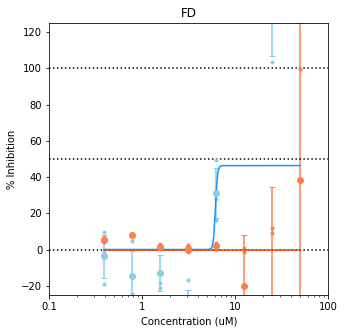

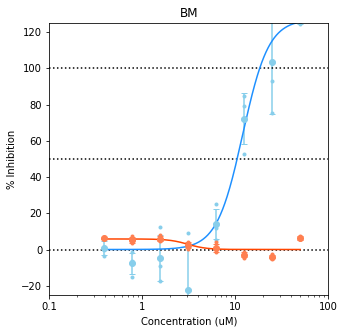

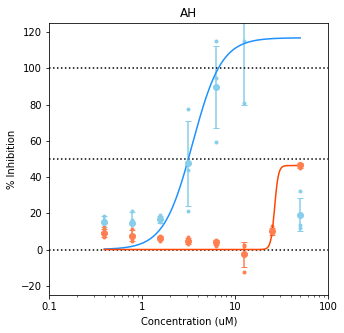

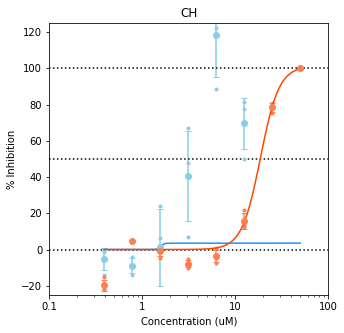

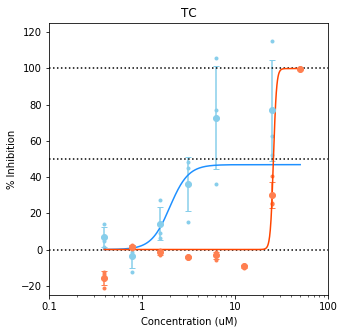

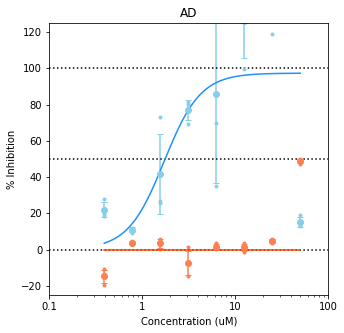

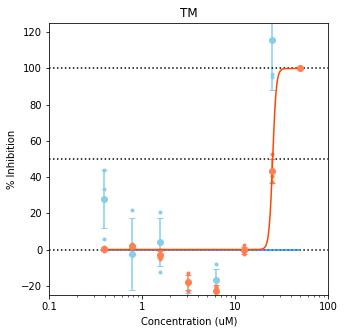

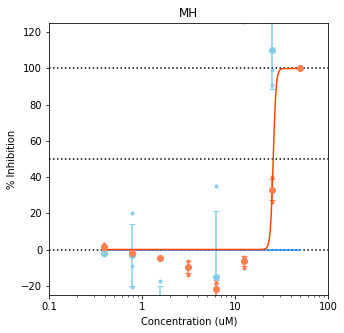

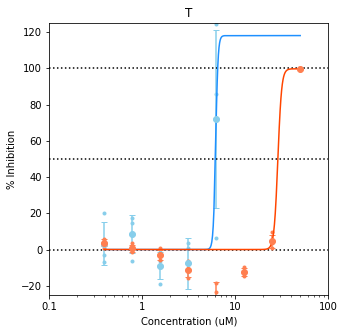

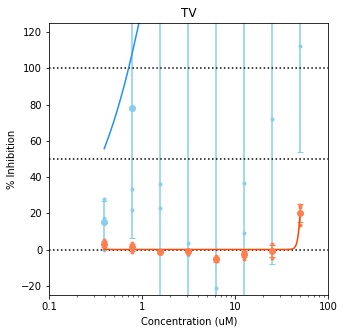

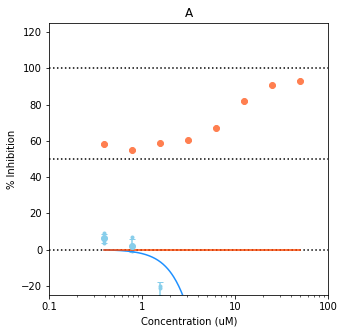

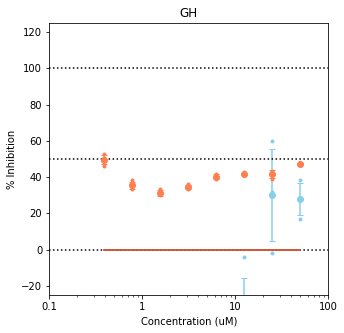

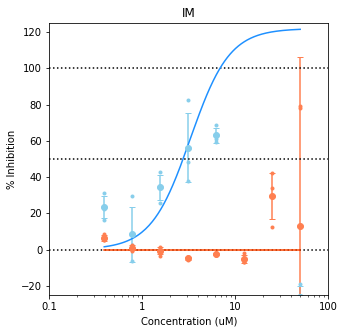

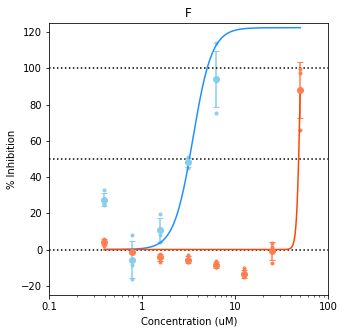

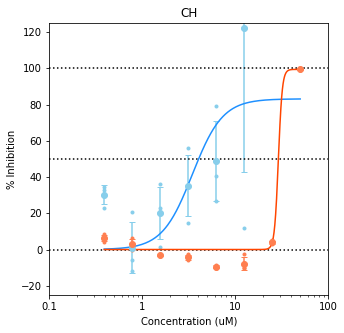

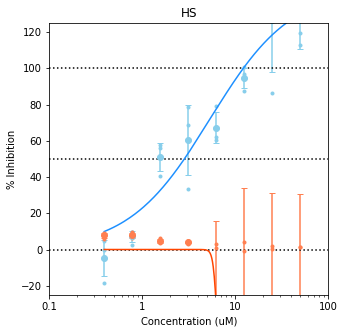

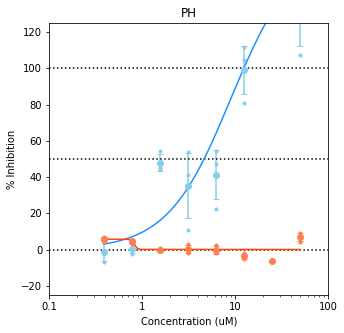

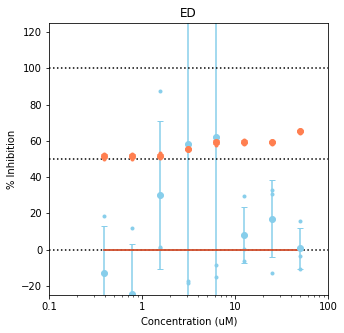

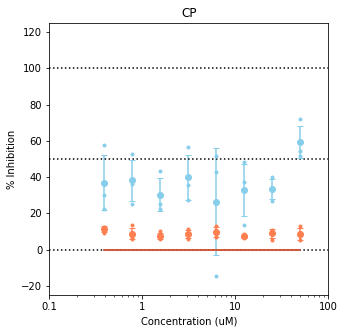

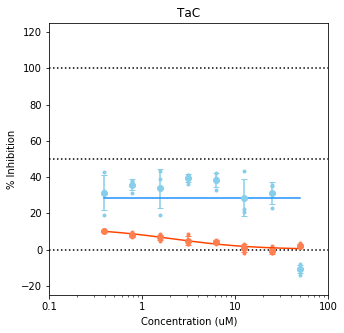

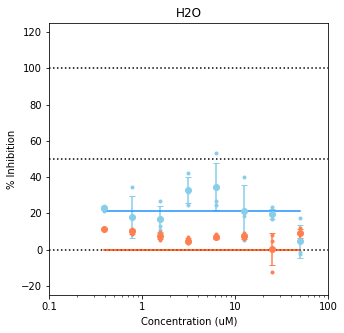

In [119]:
inhib_data = get_dict_from_excel(inhib_file, n_plates, n_columns)
tox_data = get_dict_from_excel(tox_file, n_plates, n_columns, infected=False)

for plate in range(1, n_plates+1):

    df_tox, df_inhib = get_tox_and_inhib_for_plate(inhib_data, tox_data, plate, plate_names, n_repeats, concentrations)

    plots_and_fits(df_tox, df_inhib, concentrations, n_repeats)

## Export as csv

In [115]:
def write_plate_to_csv(save_path, plate_ind, inf_data, uninf_data, plate_names):
    
    headers = ['Concentration (uM)']
    for name in plate_names[plate_ind]:
        headers.append(name)
        
    this_inf = np.asarray(inf_data[f'Plate {plate_ind}'])
    this_uninf = np.asarray(uninf_data[f'Plate {plate_ind}'])
    
    n_rows = this_inf.shape[0]
    
    with open(f'.\{save_path}\Plate_{plate_ind}_inf.csv', 'w') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',')
        csvwriter.writerow(headers)
        
        for n in range(n_rows):
            row = this_inf[n, 0:3]
            row = np.insert(row, 0, concentrations[n])
            csvwriter.writerow(row)
            
    with open(f'.\{save_path}\Plate_{plate_ind}_uninf.csv', 'w') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',')
        csvwriter.writerow(headers)
        
        for n in range(n_rows):
            row = this_uninf[n, 0:3]
            row = np.insert(row, 0, concentrations[n])
            csvwriter.writerow(row)
    

In [116]:
for i in range(n_plates):
    _plate = i+1

    write_plate_to_csv('out', _plate, inf_data_dmso_div, uninf_data_dmso_div, plate_names)

NameError: name 'inf_data_dmso_div' is not defined